In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.stats import qmc

In [4]:
def diff_eqs(input, t, parameters):
  beta = parameters[0] 
  gamma = parameters[1]
  chi = parameters[2]
  epsilon = parameters[3]
  theta = parameters[4]
  mu = parameters[5]
  tau = parameters[6] #Testing rate
  rho = parameters[7] #Result return rate
  fnr = parameters[8] #False negative rate
  fpr = parameters[9] #False positive rate

  Y = np.zeros((12)) #SIRVQD
  V = input
  N = V[0]+V[1]+V[2]+V[3]+V[4]+V[5]+V[6]+V[7]+V[8]+V[9]+V[10] #Not including dead individuals
  S_effective = V[0]+V[1]+V[2]
  V_effective = V[6]+V[7]+V[8]
  I_active = V[3]+V[4]+V[5]

  Y[0] = -beta*I_active*V[0]/N-chi-tau*V[0]
  Y[1] = -beta*I_active*V[1]/N-chi-rho*V[1]+tau*V[0]
  Y[2] = -beta*I_active*V[2]/N-chi+rho*(1-fpr)*V[1]
  Y[3] = beta*S_effective*I_active/N+epsilon*V_effective*I_active/N-gamma*V[3]-mu*V[3]-tau*V[3]
  Y[4] = -rho*V[4]+tau*V[3]
  Y[5] = rho*fnr*V[4]-gamma*V[5]-mu*V[5]
  Y[6] = -epsilon*I_active*V[6]/N+chi-tau*V[6]
  Y[7] = -epsilon*I_active*V[7]/N+chi-rho*V[7]+tau*V[6]
  Y[8] = -epsilon*I_active*V[8]/N+chi+rho*(1-fpr)*V[7]
  Y[9] = rho*fpr*V[1]+rho*(1-fnr)*V[4]+rho*fpr*V[7]-gamma*V[9]-mu*V[9]
  Y[10] = gamma*(V[3]+V[5])+gamma*V[9]
  Y[11] = mu*(V[3]+V[5])+mu*V[9]
  return Y

In [21]:
starting_infections = 0.001 # 0.1% of the total popultion starts off infected
starting_vaccinations = 0.0
INPUT_0 = np.array([1-starting_infections-starting_vaccinations, 0, 0, starting_infections, 0, 0, starting_vaccinations, 0, 0, 0, 0, 0])*10**6 # Initial values of SIRVQD scaled to a population of one million
R0 = 16
CFR = 0.0653 # Case fatality rate
gamma = 0.0714*(1-CFR)
mu = 0.0714*CFR
beta = R0*(gamma+mu)

ND_end = 100 # Number of days to simulate
t_start = 0.0; t_end = ND_end; t_inc = 0.05
t_range_init = np.arange(t_start, t_end+t_inc, t_inc) # Time points to solve the system at

In [29]:
param_bounds = {
    'chi': (0, 0.01*10**6),
    'epsilon': (0, beta),
    'theta': (0, 1),
    'tau': (0.01, 1),
    'rho': (0, 1),
    'fnr': (0, 0.5), 
    'fpr': (0, 0.5)
}

param_names = list(param_bounds.keys())

In [30]:
#Generate 1000 samples in [0, 1] for each parameter
n_samples = 1000
sampler = qmc.LatinHypercube(d=len(param_bounds))
lhs_samples = sampler.random(n=n_samples)

#Scale the samples to actual range
param_ranges = np.array([param_bounds[name] for name in param_names])
scaled_samples = qmc.scale(lhs_samples, param_ranges[:, 0], param_ranges[:, 1])

In [31]:
def simulate_model(params, I_data): 
    chi, epsilon, theta, tau, rho, fnr, fpr = params
    all_params = np.array([beta, gamma, chi, epsilon, theta, mu, tau, rho, fnr, fpr])

    RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

    I_model = RES_init[:, 3] + RES_init[:, 4] + RES_init[:, 5] #Compare the infected to the target data
    I_model = I_model[:len(I_data)]
    return I_model
    

In [32]:
def MSE_func(params, data): 
    I_model = simulate_model(params, data)
    return np.mean((I_model - data) ** 2)

In [33]:
#Loop over all samples and track the best 
I_data = np.linspace(50, 500, 100) + np.random.normal(0, 10, 100) #Change later on to be real data
best_params = None
lowest_error = np.inf
for sample in scaled_samples: 
    error = MSE_func(sample, I_data)
    if error < lowest_error: 
        lowest_error = error
        best_params = sample 
print("Best parameter set:", dict(zip(param_names, best_params)))

Best parameter set: {'chi': 7036.4231031665095, 'epsilon': 0.8913973567623034, 'theta': 0.838968519306556, 'tau': 0.7784270685183892, 'rho': 0.995304625067221, 'fnr': 0.0008189821215198397, 'fpr': 0.4801662459668336}


In [34]:
#Simulate model using the best parameter choices 
chi, epsilon, theta, tau, rho, fnr, fpr = best_params
all_params = np.array([beta, gamma, chi, epsilon, theta, mu, tau, rho, fnr, fpr])
RES_init = spi.odeint(diff_eqs,INPUT_0,t_range_init,args=(all_params,))

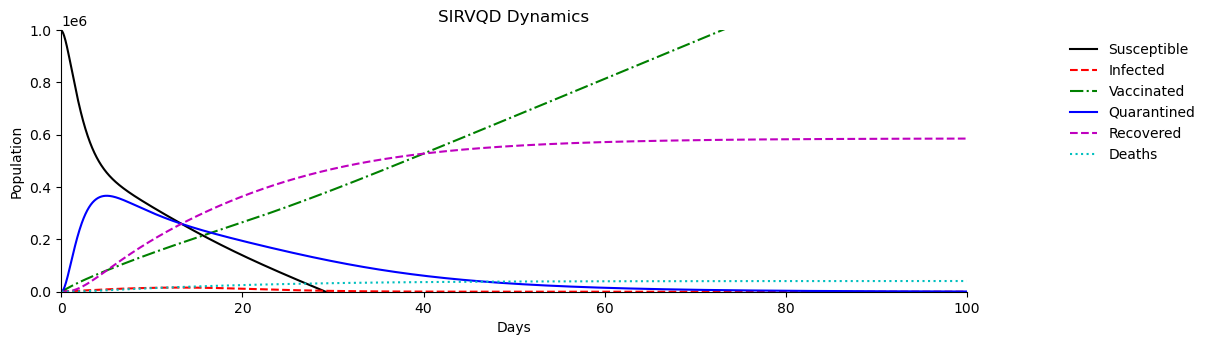

In [35]:
fig = plt.figure(figsize=(10,3.5))
ax = fig.add_subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

t_vals = np.arange(0, ND_end + t_inc, t_inc)

S_total = RES_init[:, 0] + RES_init[:, 1] + RES_init[:, 2]  # S_nt + S_wt + S_tn
I_total = RES_init[:, 3] + RES_init[:, 4] + RES_init[:, 5]  # I_nt + I_wt + I_tn
V_total = RES_init[:, 6] + RES_init[:, 7] + RES_init[:, 8]  # V_nt + V_wt + V_tn
Q = RES_init[:, 9]
R = RES_init[:, 10]
D = RES_init[:, 11]

ax.plot(t_vals, S_total, '-k', label='Susceptible') # S
ax.plot(t_vals, I_total, '--r', label='Infected') # I
ax.plot(t_vals, V_total, '-.g', label='Vaccinated') # V
ax.plot(t_vals, Q, '-b', label='Quarantined') # Q
ax.plot(t_vals, R, '--m', label='Recovered') # R
ax.plot(t_vals, D, ':c', label='Deaths') # D

ax.set_xlabel('Days')
ax.set_ylabel('Population')

plt.xlim([0,ND_end])
plt.ylim([0,sum(INPUT_0)])
plt.tight_layout()
plt.title('SIRVQD Dynamics')
plt.legend(bbox_to_anchor = (1.1, 1), loc = 'upper left', frameon=False)
plt.show()